Create a Research Agent.

In [ ]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("What are the proper guidelines for disposing of batteries in NYC?")

print(web_search_results["results"][0]["content"])

In [5]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [8]:
document = TextLoader(file_path="knowledge_base.txt").load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)
chunks = text_splitter.split_documents(document)
print(f"Split the document into {len(chunks)} chunks")

Split the document into 179 chunks


In [9]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="knowledge-base",
    embedding_function=embeddings
)

vector_store.add_documents(documents=chunks)

['4277d6cc-63fc-4b2e-a5a2-8fcf2b41a6d1',
 '71f2f7dc-65a9-4125-9198-8f465d2141e6',
 '58d0d0f1-21b3-4b48-9e80-eab90d48e095',
 'e4922b13-0f9c-44f2-8254-a670ba79a667',
 '47f9c705-4d27-4610-877a-f96bb977c4c3',
 'bebc2633-19c9-4892-a5a3-b4d27bed70c9',
 'e6914e55-b8f4-4d35-8d2f-05cb88131271',
 '96e173d9-1491-4475-80f4-7021ae25b263',
 '85a12911-2214-4a50-9eda-0c66f5752462',
 'f3c876b7-8253-45e0-ba7b-578af2c71c0a',
 'e76d99a0-c268-4bb2-8853-f556a159fe7e',
 'dd854b9e-d75e-4de4-97db-7b3d09b80577',
 '60c22ef5-de72-49e1-9274-cd1fa0b91f44',
 '728fca77-c776-49d7-9ab3-57861e59b105',
 '9e98ffd3-6d16-466f-a0dd-a5b7e2c9cf5e',
 '0bf7f4a8-f644-48b1-abe1-584a8e9a931f',
 '3b4e326b-46f2-4867-8bd6-9c539c3fc19f',
 'b388d689-1e39-47f6-af0f-62fff56f2235',
 '4ebfa168-99f7-4c74-be78-810fb0b9f896',
 '6d5d7837-e6e0-4799-b602-e3b59b642fda',
 'af54938d-d6dd-47b2-8140-8636111f9811',
 'dfa0584e-1f01-4450-b190-bfe92e797b39',
 '117a81e2-6fee-4cef-8a32-ebb041305a42',
 'ffa14fef-e436-4a08-9c85-9893fbaa50a4',
 '0468e99a-0791-

In [13]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

In [14]:
from langchain.tools.retriever import create_retriever_tool

retreival_tool = create_retriever_tool(
    retriever,
    name="regulation-knowledge-base",
    description="Use this tool to look up where and how to dispose of waste items based on the knowledge base."
)

In [18]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[retreival_tool],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- First consult the waste disposal knowledge base when possible.\n"
        "- If needed, you may use web search for additional context.\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [19]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [20]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "What are the proper guidelines for disposing of batteries in NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  regulation-knowledge-base (call_AppP2K1GS0Zsvkt1hAhvWsax)
 Call ID: call_AppP2K1GS0Zsvkt1hAhvWsax
  Args:
    query: disposal of batteries in NYC


Update from node tools:


================================= Tool Message =================================
Name: regulation-knowledge-base

Conservation maintains a list of registered recyclers.\n\nNon-Hazardous E-Waste Removal\n\nE-waste that is not classified as hazardous waste per the NY State Department of Environmental Conservation

Residents should use Curbside Composting collection or find at Smart Compost bin or community drop-off site.\n\nLocation and Hours\n450 West Service Road\nStaten Island, NY 10313\nPhone: (917)

and other safer disposal practices.\n\nThree methods of disposing syringes and other sharps collection sites exist across New York State.\n\nAll hospitals and nursing homes in 

In [22]:
import os
import requests

GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

def get_places(query: str, latitude: float, longitude: float) -> dict:
    """Function that leverages the Google Places API to find locations near the latidute and longitude given.

    Args:
        query: The type of location you are searching for (in example "Recycling center")
        latitude: The current latitude of the user
        longitude: The current longitude of the user

    Returns:
        Dictionary with location details, results and metadata
    """
    #the google api url
    url = 'https://places.googleapis.com/v1/places:searchText'
    #headers used for the request
    headers = {
        'Content-Type': 'application/json',
        'X-Goog-Api-Key': GOOGLE_API_KEY,
        'X-Goog-FieldMask': '*'
    }
    #the request body used for the api request
    request_body = {
        "textQuery": query,
        "locationBias": {
            "circle": {
                "center": {
                    "latitude": latitude,
                    "longitude": longitude
                },
                "radius": 100.0
            }
        }
    }
    #get the response
    response = requests.post(url, headers=headers, json=request_body)
    #get the json object
    output = response.json()
    #save the locations in a dictionary
    locations = []
    #loop through the output
    for row in output['places']:
        locations.append({
            "name": row["displayName"]["text"],
            "address": row["formattedAddress"],
            #TODO: contact information
        })
    return {
        "query": query,
        "latitude_used": latitude,
        "longitude_used": longitude,
        "results": locations
    }

def geolocate_ip(ip: str = None) -> dict:
    """Function that locates the users location by latitude and longitude by their IP address.

        Args:
            ip (optional): IP address to check. If none, uses caller's IP.

        Returns:
            Dictionary with latitude and longitude of IP address OR error message
    """

    url = f"http://ip-api.com/json/{ip or ''}"

    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()

        geo_data = response.json()

        if geo_data.get("status") != "success":
            raise ValueError(f"Geolocation Lookup Failed {geo_data}")
        else:
            return {"latitude": geo_data["lat"], "longitude": geo_data["lon"]}
    except Exception as e:
        return {"error": str(e)}




In [24]:
locater_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[get_places, geolocate_ip],
    prompt=(
        "You are a locater agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with locating-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="locater_agent",
)

In [25]:
for chunk in locater_agent.stream(
    {"messages": [{"role": "user", "content": "Where can I dispose of my batteries"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: locater_agent
Tool Calls:
  geolocate_ip (call_rRgHJH5grzFAtsjJTKTMODRM)
 Call ID: call_rRgHJH5grzFAtsjJTKTMODRM
  Args:


Update from node tools:


================================= Tool Message =================================
Name: geolocate_ip

{"latitude": 40.9266, "longitude": -74.1818}


Update from node agent:


================================== Ai Message ==================================
Name: locater_agent
Tool Calls:
  get_places (call_qbUxyWWrPt9fHueKYNxqhaim)
 Call ID: call_qbUxyWWrPt9fHueKYNxqhaim
  Args:
    query: battery disposal
    latitude: 40.9266
    longitude: -74.1818


Update from node tools:


================================= Tool Message =================================
Name: get_places

{"query": "battery disposal", "latitude_used": 40.9266, "longitude_used": -74.1818, "results": [{"name": "Hawthorne Recycling Center", "address": "Ryerson Wa

#### Supervisor Agent

In [28]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1-mini"),
    agents=[research_agent, locater_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent, such as more information on city guidelines.\n"
        "- a locater agent. Assign locating-related tasks to this agent, such as finding places near a specific area.\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "You should use the research agent to inform yourself on the appropriate guidelines and then use the locater agent to give five locations for the user.\n"
        "You must also inform the user of any fines they could incur if they do not follow the guidelines.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

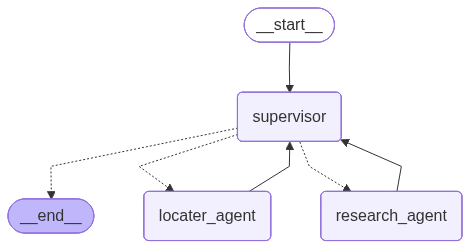

In [29]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [31]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Hello, somebody ran over a racoon and left it on the street, what should I do?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_locater_agent

Successfully transferred to locater_agent


Update from node locater_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

A dead raccoon is considered contaminated animal carcass waste and should be handled with care. I

In [32]:
print(chunk["supervisor"]['messages'][-1].content)

A dead raccoon is considered contaminated animal carcass waste and should be handled with care. In New York State, medical waste disposal regulations apply, and the raccoon can be removed either by a private carter or by yourself if you register as a self-hauler. Alternatively, residents may use curbside composting services or drop-off at designated Smart Compost bins or community sites.

To help you, here are some local animal carcass removal services near you:

1. Kritter Catchers NJ, 115 Hillside Ave, Nutley, NJ 07110
2. Wayne Twp Animal Control, 475 Valley Rd, Wayne, NJ 07470
3. Reliable Pest and Animal Control, 178 Behnke Ave, Paramus, NJ 07652
4. Chaos Wildlife Solutions of Westchester, 515 Decatur Ave, Peekskill, NY 10566
5. Animal Damage Control Systems, 41 Buchanan Rd, Metuchen, NJ 08840

Please handle the raccoon with gloves and avoid direct contact to prevent health risks. Not adhering to disposal guidelines may result in fines or penalties as these are considered regulated 